# **EDA and Preprocessing for Machine Learning**

Exploratory Data Analysis (EDA) and data preprocessing are critical steps in preparing data for machine learning. This chapter explores techniques for handling missing data, encoding categorical variables, identifying and managing outliers, analyzing feature distributions, and scaling the data to ensure compatibility with algorithms.

---

## **1. Loading the Dataset and Initial Exploration**

### **Steps**
1. **Load the Dataset**: Import the data and examine its structure.
2. **Handle Missing Data**: Check for missing values and remove or impute them.
3. **Check for Duplicates**: Identify and handle duplicate rows.
4. **Descriptive Statistics**: Summarize key statistics for numerical and categorical features.

In [1]:
import pandas as pd

In [2]:
# Load the dataset
df = pd.read_csv("Data/raw.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
# Handle missing data
df = df.dropna(subset=['sex']).reset_index(drop=True)

In [6]:
# Check for missing values and duplicates
print("\nMissing Values per Column:")
print(df.isnull().sum())
print("\nNumber of Duplicate Rows:", df.duplicated().sum())


Missing Values per Column:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Number of Duplicate Rows: 0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bill_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
bill_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0


### **Explanation**
- **Missing Values**: Dropping rows with missing `sex` ensures that the target variable is complete.
- **Duplicates**: Checking for duplicates ensures data consistency.
- **Statistical Summary**: Describes the central tendency and spread of numerical data.

**Target Variable Distribution**:

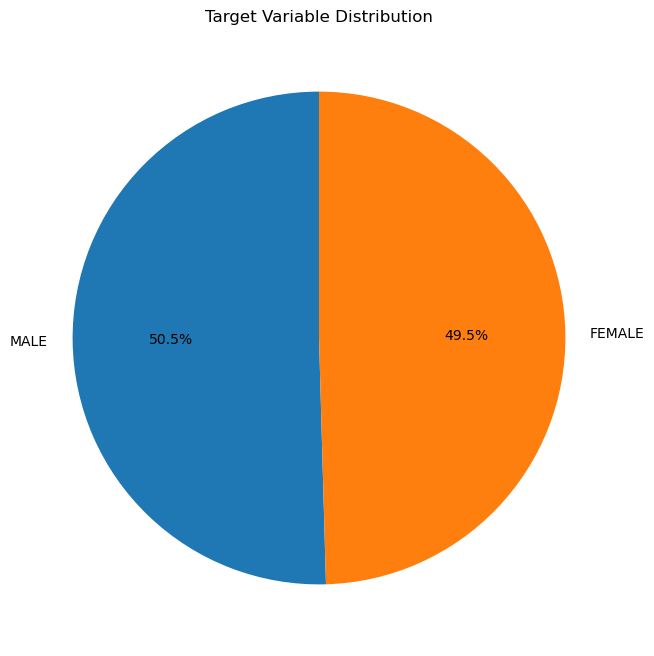

In [8]:
import matplotlib.pyplot as plt

# Visualize the target variable distribution
plt.figure(figsize=(8, 8))
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Target Variable Distribution')
plt.ylabel('')
plt.show()

**Based on this chart, the data appears to be well-balanced.**

---

## **2. Encoding Categorical Variables**

In [9]:
print(f"The unique for  {df['sex'].value_counts()}")
print(f"{"---"*10}\n The unique for {df['species'].value_counts()}")
print(f"{"---"*10}\n The unique for {df['island'].value_counts()}")

The unique for  sex
MALE      168
FEMALE    165
Name: count, dtype: int64
------------------------------
 The unique for species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64
------------------------------
 The unique for island
Biscoe       163
Dream        123
Torgersen     47
Name: count, dtype: int64


### **Why Encoding is Necessary**
Machine learning algorithms require numerical input. Encoding transforms categorical variables into numerical formats that models can process.

### **Types of Encoding**
1. **Binary Encoding**:
   - Used for binary categorical variables (e.g., `sex`).
   - Example: `FEMALE → 0`, `MALE → 1`.

   $
   \text{Encoded Value} = 
   \begin{cases} 
   0 & \text{if FEMALE} \\
   1 & \text{if MALE}
   \end{cases}
   $

2. **One-Hot Encoding**:
   - Used for nominal variables with more than two categories (e.g., `species`, `island`).
   - Creates separate binary columns for each category.

In [10]:
# Binary encoding for 'sex'
df['sex'] = df['sex'].map({'FEMALE': 0, 'MALE': 1})

##### **`species`**
- **Details**: The column contains three categories: `Adelie`, `Gentoo`, `Chinstrap`.
- **Best Encoding**:
  - **One-Hot Encoding**: Since `species` is a nominal variable (no inherent order), use one-hot encoding.
 
##### **`island`**
- **Details**: The column contains three categories: `Biscoe`, `Dream`, `Torgersen`.
- **Best Encoding**:
  - **One-Hot Encoding**: Similar to `species`, this is a nominal variable and should be one-hot encoded.

In [11]:
# One-Hot Encoding for 'species' and 'island'
df = pd.get_dummies(df, columns=['species', 'island'], drop_first=True)

##### **Why These Choices?**
- **Binary Encoding** for `sex` minimizes the number of columns since it's binary.
- **One-Hot Encoding** for `species` and `island` avoids introducing ordinal relationships and captures the distinct categories effectively.

**Correlation Heatmap After Encoding**:

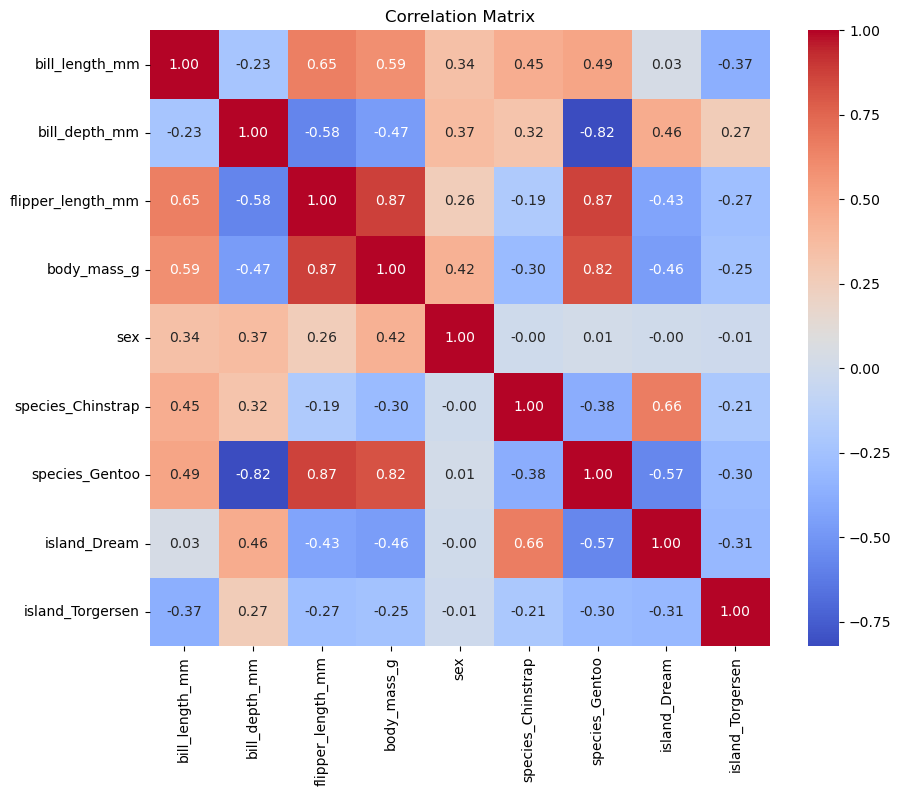

In [12]:
import seaborn as sns

# Correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

---

## **3. Detecting Multicollinearity**

### **What is Multicollinearity?**
Multicollinearity occurs when two or more independent variables are highly correlated, which can cause instability in model predictions. It is quantified using:
1. **Correlation Matrix**.
2. **Variance Inflation Factor (VIF)**:

$
\text{VIF}_i = \frac{1}{1 - R^2_i}
$

Where:
- $(R^2_i)$: Coefficient of determination of feature $(i)$.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for numeric features
X = df.select_dtypes(include=['float64', 'int64'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,bill_length_mm,121.447678
1,bill_depth_mm,86.196104
2,flipper_length_mm,482.061955
3,body_mass_g,154.176479
4,sex,4.177567


##### **Handling Multicollinearity**

##### 1. **Feature Removal**
- Drop one of the highly correlated features.
- Choose based on domain knowledge or feature importance.

In [14]:
# Drop feature with high VIF
df = df.drop(columns=['flipper_length_mm'])

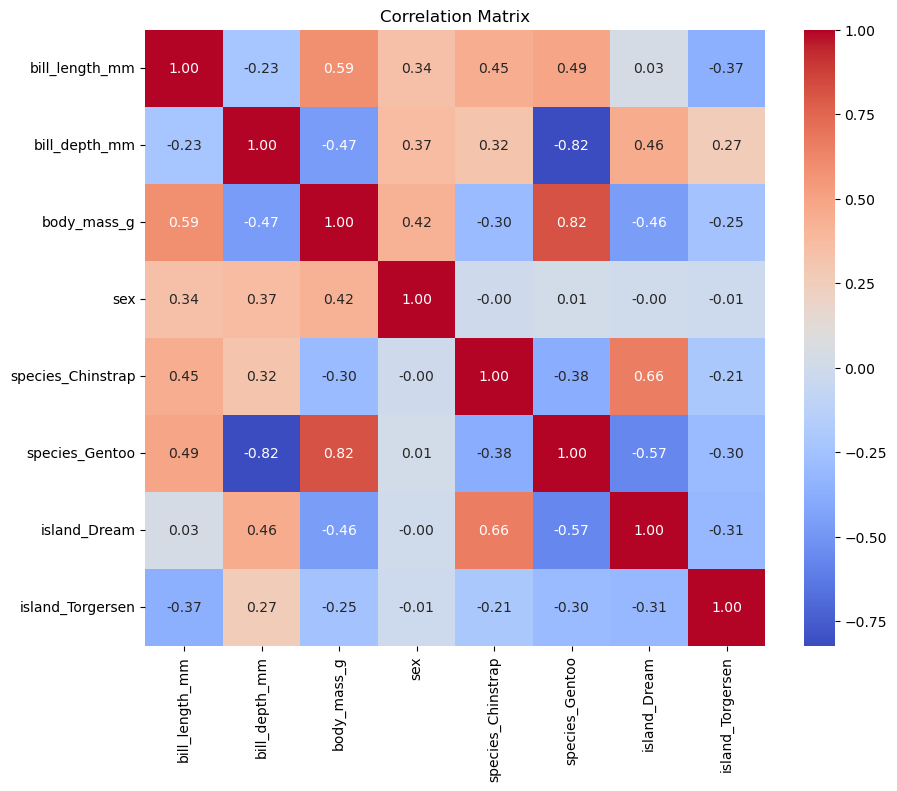

In [15]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

---

## **4. Outlier Detection**

### **What are Outliers?**
Outliers are extreme values that deviate significantly from other observations. They can be detected using:
1. **Boxplots**.
2. **Z-Score Method**:

$
Z = \frac{X - \mu}{\sigma}
$

Where:
- $(X)$: Data point.
- $(\mu)$: Mean of the data.
- $(\sigma)$: Standard deviation.

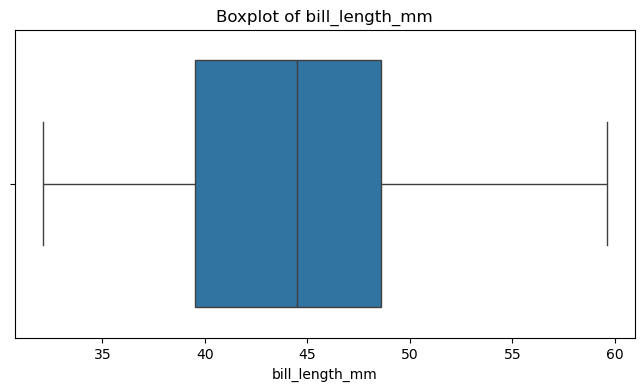

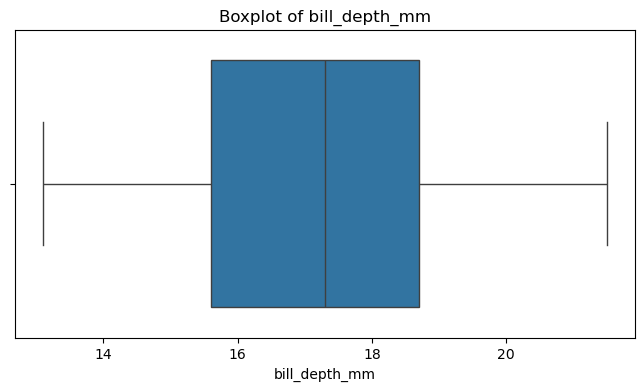

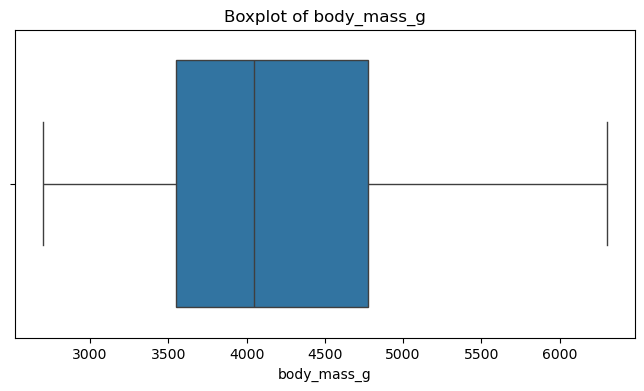

In [16]:
from scipy.stats import zscore

# Boxplots for numeric features
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'body_mass_g']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

In [17]:
# Z-Score outlier detection
z_scores = df[numeric_features].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print("Outliers Detected:\n", outliers.sum())

Outliers Detected:
 0


---

## **5. Analyzing Feature Distributions**

### **Skewness**
Skewness measures the asymmetry of a distribution. A skewness value:
- \(> 0\): Right skewed.
- \(< 0\): Left skewed.
- \(= 0\): Symmetrical.

In [18]:
# Skewness calculation
skewness = df[numeric_features].skew()
print("Skewness of Features:\n", skewness)

Skewness of Features:
 bill_length_mm    0.045340
bill_depth_mm    -0.149720
body_mass_g       0.472246
dtype: float64


| **Feature**         | **Skewness** | **Interpretation**                        |
|----------------------|--------------|------------------------------------------|
| `bill_length_mm`     | 0.045        | Symmetrical (close to 0, no skew).       |
| `bill_depth_mm`      | -0.150       | Slightly left-skewed (near symmetric).   |
| `body_mass_g`        | 0.472        | Moderately right-skewed.                 |

---

### **What Does This Mean?**

1. **`bill_length_mm`**:
   - The feature is symmetric, so no transformation is necessary.

2. **`bill_depth_mm`**:
   - Slight left skew, but the value is very close to 0, so no action is required unless further analysis indicates a need for transformation.

3. **`body_mass_g`**:
   - The skew is moderate (close to 0.5), which might benefit from a **logarithmic** or **square root** transformation if the feature impacts the model negatively (e.g., affecting normality-based models like Logistic Regression).

---

### **Addressing Skewness**
1. **Log Transformation**:

$
X' = \log(X + 1)
$

2. **Square Root Transformation**:

$
X' = \sqrt{X}
$

In [19]:
import numpy as np

# Log and square root transformations
df['log_body_mass_g'] = np.log1p(df['body_mass_g'])
df['sqrt_body_mass_g'] = np.sqrt(df['body_mass_g'])

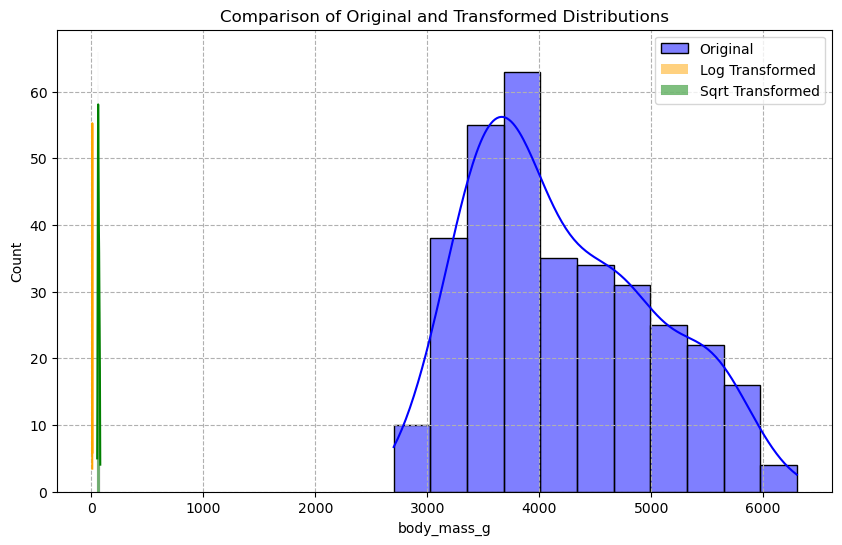

In [20]:
# Plot transformed distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['body_mass_g'], kde=True, color='blue', label='Original', alpha=0.5)
sns.histplot(df['log_body_mass_g'], kde=True, color='orange', label='Log Transformed', alpha=0.5)
sns.histplot(df['sqrt_body_mass_g'], kde=True, color='green', label='Sqrt Transformed', alpha=0.5)
plt.title('Comparison of Original and Transformed Distributions')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

This chart shows a comparison of the **original distribution** and its **logarithmic** and **square root transformations** for the `body_mass_g` feature. However, the log and square root transformed distributions are compressed into a narrow range due to the large range of values in the original feature (`body_mass_g`), making them difficult to interpret. 

This behavior indicates a strong need for **scaling** the data.

---

## **6. Scaling and Normalization**

### **Why Scaling is Necessary**
Scaling ensures that features contribute equally to model performance. Methods include:
1. **Min-Max Scaling**: Scales values to \([0, 1]\).
2. **Standardization**: Scales to zero mean and unit variance.

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()

normalized_features = scaler.fit_transform(df[['body_mass_g', 'log_body_mass_g', 'sqrt_body_mass_g']])

df_normalized = pd.DataFrame(normalized_features, columns=['Original', 'Log Transformed', 'Sqrt Transformed'])

### **Why Scaling is Necessary**
1. **Feature Magnitude Disparity**:
   - The original `body_mass_g` feature has a large range (e.g., 3000–6000).
   - Log and square root transformations significantly reduce the range, but without scaling, these features remain difficult to compare on the same scale.

2. **Effect on Machine Learning Models**:
   - Algorithms such as **Logistic Regression**, **KNN**, and **SVM** use gradients or distances that are sensitive to feature magnitudes.
   - Without scaling, features with larger magnitudes (e.g., `body_mass_g`) dominate the model, leading to biased predictions.

3. **Improved Interpretability**:
   - Scaling normalizes the feature values, enabling direct comparisons between the original and transformed distributions.
   - It ensures that the transformed values maintain proportional relationships while being adjusted to a uniform range.

---

### **Scaling Method: Min-Max Scaling**
Min-Max Scaling transforms the feature values to a specified range (typically [0, 1]) using the formula:

$
X' = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$

Where:
- $(X')$: Scaled value.
- $(X)$: Original value.
- $(X_{\text{min}})$: Minimum value of the feature.
- $(X_{\text{max}})$: Maximum value of the feature.

---

### **Expected Outcome After Scaling**
- The transformed features (`log_body_mass_g` and `sqrt_body_mass_g`) will be scaled to the same range as the original feature.
- This ensures compatibility with machine learning algorithms and allows for meaningful comparisons.

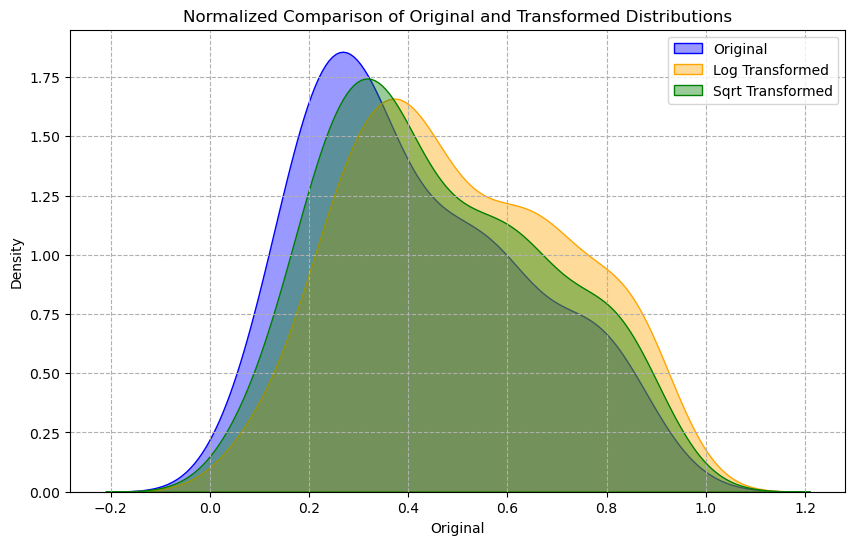

In [22]:
# Plot normalized distributions
colors = ['blue', 'orange', 'green' , 'red' ,'yellow' , 'white']

plt.figure(figsize=(10, 6))
for col, color in zip(df_normalized.columns, colors):
    sns.kdeplot(df_normalized[col], color=color, label=col, fill=True, alpha=0.4)
plt.title('Normalized Comparison of Original and Transformed Distributions')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [23]:
features_to_scale = ['body_mass_g',
                     'bill_length_mm',
                     'bill_depth_mm' ,
                     'log_body_mass_g',
                     'sqrt_body_mass_g']

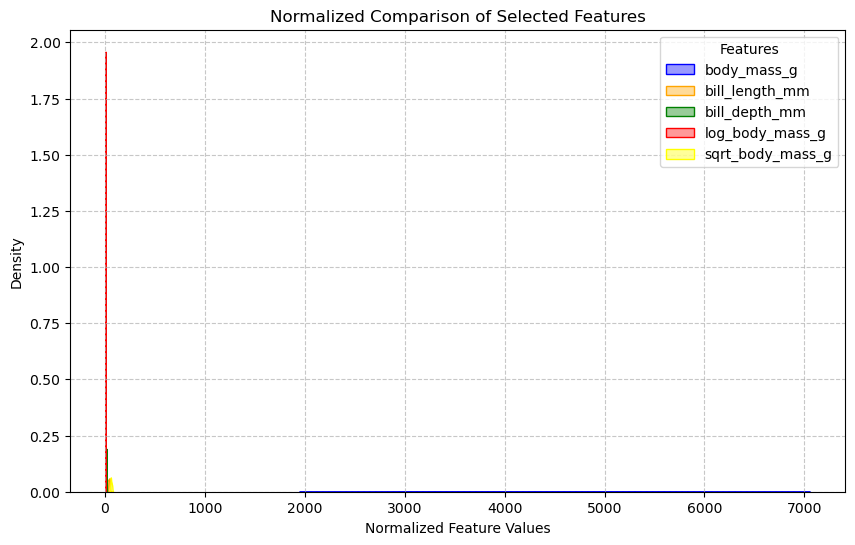

In [24]:
plt.figure(figsize=(10, 6))
for col, color in zip(features_to_scale, colors):
    sns.kdeplot(df[col], color=color, label=col, fill=True, alpha=0.4)

plt.title('Normalized Comparison of Selected Features')
plt.xlabel('Normalized Feature Values')
plt.ylabel('Density')
plt.legend(title='Features')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [25]:
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

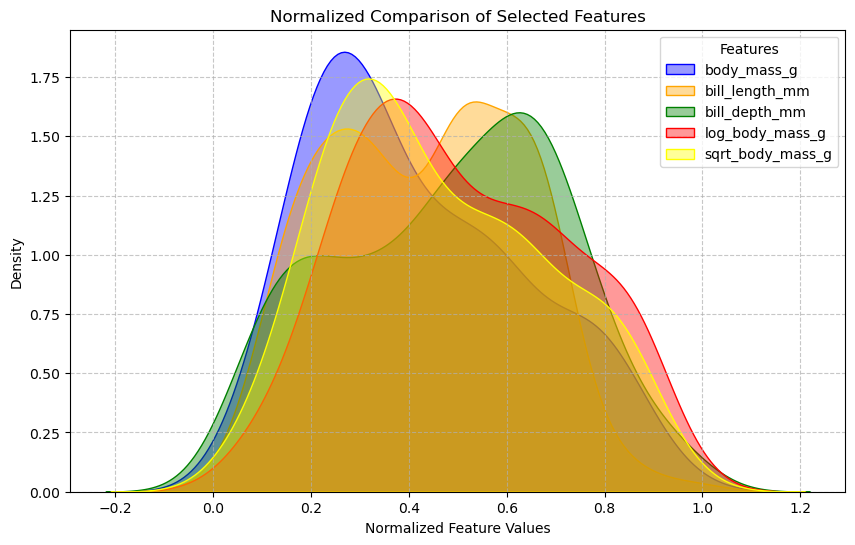

In [26]:
plt.figure(figsize=(10, 6))

for col, color in zip(features_to_scale, colors):
    sns.kdeplot(df[col], color=color, label=col, fill=True, alpha=0.4)

plt.title('Normalized Comparison of Selected Features')
plt.xlabel('Normalized Feature Values')
plt.ylabel('Density')
plt.legend(title='Features')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


---

In [27]:
df.head()

,bill_length_mm,bill_depth_mm,body_mass_g,sex,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,log_body_mass_g,sqrt_body_mass_g
0,0.254545,0.666667,0.291667,1,False,False,False,True,0.387682,0.338394
1,0.269091,0.511905,0.305556,0,False,False,False,True,0.403314,0.353238
2,0.298182,0.583333,0.152778,0,False,False,False,True,0.218798,0.184132
3,0.167273,0.738095,0.208333,0,False,False,False,True,0.289276,0.247170
4,0.261818,0.892857,0.263889,1,False,False,False,True,0.355783,0.308405


In [28]:
df.to_csv("Data/scaled_data_with_log_sqrt.csv", index=False)

In [29]:
df.drop(columns=['log_body_mass_g', 'sqrt_body_mass_g'] , inplace=True)

In [30]:
df.to_csv("Data/scaled_data.csv", index=False)

## **Conclusion**
This chapter demonstrated how to:
1. Conduct EDA to understand data structure and quality.
2. Encode categorical variables and handle multicollinearity.
3. Detect and address outliers.
4. Analyze and transform feature distributions.
5. Scale data for compatibility with machine learning algorithms.